In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sys_path #this includes all necessary folders in PYTHONPATH
import timeseries

%matplotlib inline

#### Import data into dataframes

In [2]:
arr_energy = []
base = 'monthly'

ts = timeseries.TimeSeries(base)
ts.get_energy_data()

arr_energy.append(ts.energy[ts.energy['Park'] == 'Wind Park 1'].drop(columns = ['Park']))
arr_energy.append(ts.energy[ts.energy['Park'] == 'Wind Park 2'].drop(columns = ['Park']))
arr_energy.append(ts.energy[ts.energy['Park'] == 'Wind Park 3'].drop(columns = ['Park']))
df_temp, df_wind = ts.get_meteorological_data()

#### Checking the data

* Output data:

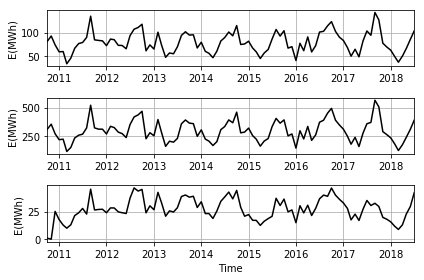

In [3]:
fig_en, axs_en = plt.subplots(3, 1)
for i in range(3):
    axs_en[i].plot(arr_energy[i]['Date'], arr_energy[i]['Energy']/1000, 'k')
    axs_en[i].set_ylabel('E(MWh)')
    axs_en[i].grid(True)
    axs_en[i].set_xlim(arr_energy[i]['Date'].min(), arr_energy[i]['Date'].max())

axs_en[i].set_xlabel('Time') 
fig_en.tight_layout()

plt.show()

* Exogenous data:

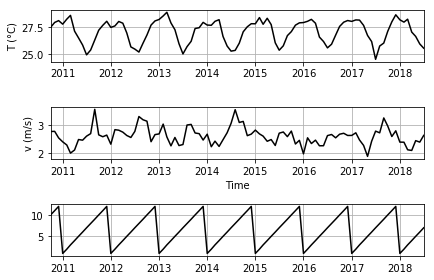

In [4]:
#Ramp-like exogenous data:
ramp = []

if base == 'weekly':
    ramp = np.array(arr_energy[0]['Week'])
elif base == 'daily':
    ramp = np.array(arr_energy[0]['Date'].dt.day)
else:
    ramp = np.array(arr_energy[0]['Date'].dt.month)

fig_met, axs_met = plt.subplots(3, 1)

axs_met[0].plot(df_temp['Date'], df_temp['Average Temperature'], 'k')
axs_met[0].set_xlim(df_temp['Date'].min(), df_temp['Date'].max())
axs_met[0].set_ylabel('T (°C)')
axs_met[0].grid(True)

axs_met[1].plot(df_wind['Date'], df_wind['Average Wind Speed'], 'k')
axs_met[1].set_xlim(df_wind['Date'].min(), df_wind['Date'].max())
axs_met[1].set_ylabel('v (m/s)')
axs_met[1].set_xlabel('Time')
axs_met[1].grid(True)

axs_met[2].plot(df_wind['Date'], ramp, 'k')
axs_met[2].set_xlim(df_temp['Date'].min(), df_temp['Date'].max())
axs_met[2].grid(True)

fig_met.tight_layout()

plt.show()

#### AR Model

Lag: 11
Coefficients: [ 0.09476676  0.31140513  0.21381268 -0.26233568 -0.17484398 -0.02866543
 -0.06205581  0.00318191 -0.19852848 -0.09326123  0.11756814  0.16913857]
Test MSE: 297861166.022
Test Fit: 77.969


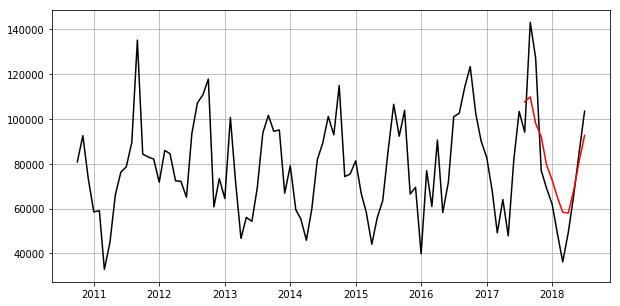

In [5]:
from sklearn.metrics import mean_squared_error
import ar_model

test_size = 12
data, mean, std = ts.normalize_z_score(arr_energy[0], 'Energy', test_size)

AR = ar_model.ARModel(np.array(data['Energy']), test_size)
predictions = AR.run_AR()

error = mean_squared_error(AR.test*std + mean, predictions*std + mean)
fit = (1 - np.sqrt(error)/mean)*100
print('Test MSE: %.3f' % error)
print('Test Fit: %.3f' % fit)

fig = plt.figure(figsize=(10,5))
plt.plot(data['Date'], arr_energy[0]['Energy'], 'k', data['Date'][-test_size:], predictions * std + mean, 'r')
plt.grid(True)
plt.show()

#### ARX Model

* Ramp Input:

* Wind Speed:

#### ARMA Model

Lag: 3
Coefficients: [ 0.04255919  1.77382481 -1.08285726  0.06400535 -1.59328289  0.83481548]
Test MSE: 364887756.632
Test Fit: 75.616


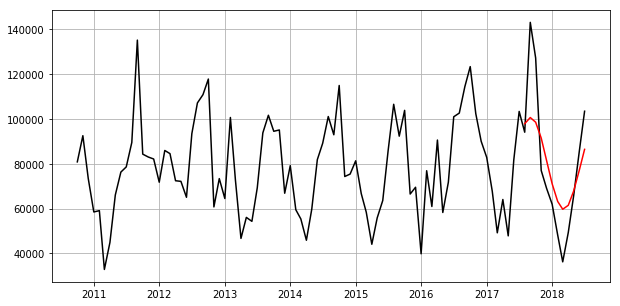

In [7]:
import arma_model
import warnings

warnings.filterwarnings('ignore')

ARMA = arma_model.ARMAModel(np.array(data['Energy']), test_size)
predictions = ARMA.run_ARMA()

error = mean_squared_error(ARMA.test*std + mean, predictions*std + mean)
fit = (1 - np.sqrt(error)/mean)*100
print('Test MSE: %.3f' % error)
print('Test Fit: %.3f' % fit)

fig = plt.figure(figsize=(10,5))
plt.plot(data['Date'], arr_energy[0]['Energy'], 'k', data['Date'][-test_size:], predictions * std + mean, 'r')
plt.grid(True)
plt.show()

#### ARMAX Model

* Ramp Input:

Lag: 3
Coefficients: [ 0.33981099 -0.04878391  1.87536697 -1.24872333  0.14367559 -1.7399226
  0.99999999]
Test MSE: 325800095.519
Test Fit: 76.959


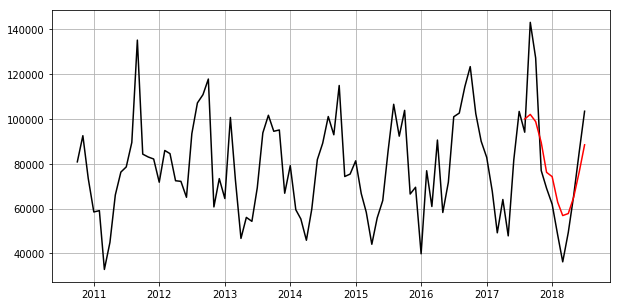

In [8]:
predictions = ARMA.run_ARMAX(exogenous_data = ramp)

error = mean_squared_error(ARMA.test*std + mean, predictions*std + mean)
fit = (1 - np.sqrt(error)/mean)*100
print('Test MSE: %.3f' % error)
print('Test Fit: %.3f' % fit)

fig = plt.figure(figsize=(10,5))
plt.plot(data['Date'], arr_energy[0]['Energy'], 'k', data['Date'][-test_size:], predictions * std + mean, 'r')
plt.grid(True)
plt.show()

warnings.filterwarnings('default')